![banner](https://github.com/hello-robot/stretch_mujoco/raw/main/docs/stretch_mujoco.png)

<h1><center>Getting Started Tutorial  <a href="https://colab.research.google.com/github/hello-robot/stretch_mujoco/blob/main/docs/getting_started.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introduction to Stretch's [**MuJoCo** simulation](https://github.com/hello-robot/stretch_mujoco/). You can run this notebook with either **CPU** or **GPU** instance.


## Install

In [1]:
# Set up Stretch Mujoco repo
%rm -rf ./stretch_mujoco/
# !git clone https://github.com/hello-robot/stretch_mujoco --recurse-submodules --branch temp
!git clone https://github.com/hello-robot/stretch_mujoco --branch temp
%pip install -e "./stretch_mujoco/"
%cd ./stretch_mujoco/

# Check if we can use GPU rendering
import os
import subprocess
try:
    subprocess.run('nvidia-smi')
    USE_GPU=True
except:
    USE_GPU=False

# Setup rendering
if USE_GPU:
    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }""")

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl
else:
    # Required for OSMesa OpenGL driver
    !apt-get update
    !apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3

    print('Setting environment variable to use CPU rendering:')
    %env MUJOCO_GL=osmesa

# Other imports and helper functions
import time
import pprint
import itertools
import numpy as np

# Graphics and plotting.
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Cloning into 'stretch_mujoco'...
remote: Enumerating objects: 1304, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 1304 (delta 216), reused 217 (delta 193), pack-reused 959 (from 2)
Receiving objects: 100% (1304/1304), 23.84 MiB | 12.80 MiB/s, done.
Resolving deltas: 100% (782/782), done.
Obtaining file:///content/stretch_mujoco
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━

## Basics

In [2]:
from stretch_mujoco import StretchMujocoSimulator

The `StretchMujocoSimulator` class is used to:

 - Start/stop the simulation
 - Read camera imagery
 - Read lidar scans
 - Read joint states
 - Position control the robot's ranged joints
 - Velocity control the robot's mobile base

In [3]:
from stretch_mujoco.enums.stretch_sensors import StretchSensors
from stretch_mujoco.enums.stretch_cameras import StretchCameras
from stretch_mujoco.enums.actuators import Actuators

The `enums` module defines actuators and sensors that can be accessed through the simulator.

### Starting the simulation

We create `sim`, and instance of the simulation class and launch it in the background using the `start()` method. Since we're in Google Colab, we'll run the simulation "headless", or without the interactive GUI. Headless is also the most performant mode, so it's used most often.

In [4]:
sim = StretchMujocoSimulator(cameras_to_use=StretchCameras.all())
sim.start(headless=True)

Starting Stretch Mujoco Simulator...
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
Still waiting to connect to the Mujoco Simulatior.
The Mujoco Simulatior is connected.


### Wall time vs. sim time

The rate of time on your clock isn't the same rate of time passing in your simulation. The speed of simulation won't exceed realtime (by default), but can be slower due to hardware (e.g. if you're using a Colab CPU instance instead of a T4 GPU instance, you'll see slower simulation).

In [5]:
wall_start = time.time()
sim_start = sim.pull_status().time

for _ in range(10):
    time.sleep(0.5)
    print(f"Sim is running {(sim.pull_status().time - sim_start)/(time.time() - wall_start):.3f}x as fast as realtime")
    wall_start = time.time()
    sim_start = sim.pull_status().time

Sim is running 0.140x as fast as realtime
Sim is running 0.148x as fast as realtime
Sim is running 0.136x as fast as realtime
Sim is running 0.110x as fast as realtime
Sim is running 0.158x as fast as realtime
Sim is running 0.155x as fast as realtime
Sim is running 0.128x as fast as realtime
Sim is running 0.116x as fast as realtime
Sim is running 0.119x as fast as realtime
Sim is running 0.116x as fast as realtime


The simulation can run faster when there are fewer cameras to simulate. Above, we defined

```
sim = StretchMujocoSimulator(cameras_to_use=StretchCameras.all())
```

If we reduced to only the cameras we needed (e.g. `cameras_to_use=[StretchCameras.cam_d435i_rgb]`), or no cameras if they're not needed (e.g. `cameras_to_use=[]`), then you'd see a higher speed.

### Imagery

MuJoCo renders simulated imagery from Stretch's two depth cameras and one wide-angle camera, for a total of 5 different images. The camera intrinsics are also provided.



1.   RGB and Depth images from [Stretch's head Realsense D435if](https://docs.hello-robot.com/0.3/getting_started/stretch_hardware_overview/#head-camera)
2.   RGB and Depth images from [Stretch's wrist Realsense D405](https://docs.hello-robot.com/0.3/getting_started/stretch_hardware_overview/#dexterous-wrist)
3.   RGB image from [Stretch's head Arducam 1MP Wide-angle](https://docs.hello-robot.com/0.3/getting_started/stretch_hardware_overview/#arducam-wide-angle-color-camera)



In [6]:
cams_current = sim.pull_camera_data()
pprint.pprint(cams_current)

StatusStretchCameras(time=0.6940000000000005,
                     fps=12.884524204116104,
                     cam_d405_rgb=array([[[169, 224, 255],
        [169, 224, 255],
        [169, 224, 255],
        ...,
        [169, 224, 255],
        [169, 224, 255],
        [169, 224, 255]],

       [[169, 224, 255],
        [169, 224, 255],
        [169, 224, 255],
        ...,
        [169, 224, 255],
        [169, 224, 255],
        [169, 224, 255]],

       [[169, 224, 255],
        [169, 224, 255],
        [169, 224, 255],
        ...,
        [169, 224, 255],
        [169, 224, 255],
        [169, 224, 255]],

       ...,

       [[179,  45,  45],
        [179,  45,  45],
        [180,  45,  45],
        ...,
        [155, 130,  97],
        [150, 125,  93],
        [146, 120,  90]],

       [[179,  45,  45],
        [179,  45,  45],
        [180,  45,  45],
        ...,
        [158, 133, 100],
        [153, 128,  96],
        [147, 122,  91]],

       [[179,  45,  45],
        [179

cam_d405_rgb,cam_d405_depth,cam_d435i_rgb,cam_d435i_depth,cam_nav_rgb

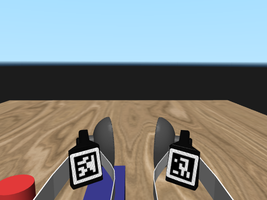
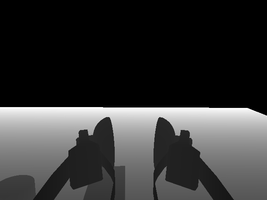
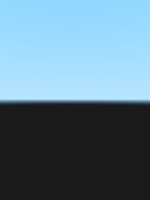
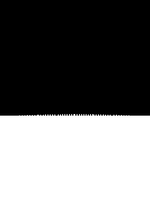
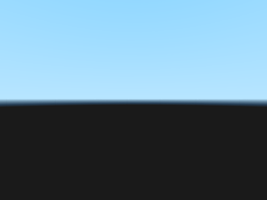

In [7]:
import cv2

images = {
    'cam_d405_rgb': cams_current.cam_d405_rgb,
    'cam_d405_depth': cams_current.cam_d405_depth,
    'cam_d435i_rgb': cv2.rotate(cams_current.cam_d435i_rgb, cv2.ROTATE_90_CLOCKWISE),
    'cam_d435i_depth': cv2.rotate(cams_current.cam_d435i_depth, cv2.ROTATE_90_CLOCKWISE),
    'cam_nav_rgb': cams_current.cam_nav_rgb,
}
media.show_images(images, vmin=0.0, vmax=1.0, border=True, height=200)

Just like on the real Stretch robot, the D435if is mounted 90 sideways (to maximize vertical fov). We use `cv2.rotate()` to correct it.

### Lidar

Stretch has a [2D planar lidar](https://docs.hello-robot.com/0.3/getting_started/stretch_hardware_overview/#rplidar-a1) attached to its mobile base, useful for localization and building maps.

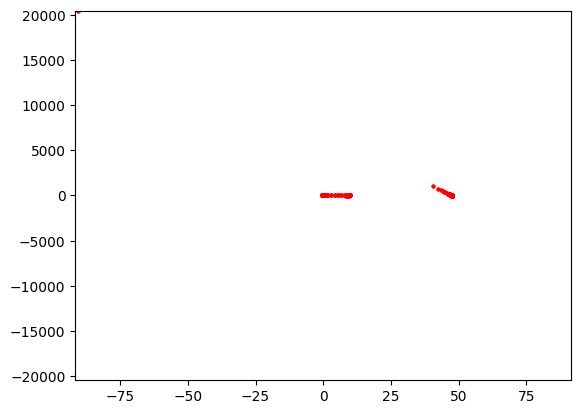

In [8]:
scan = sim.pull_sensor_data().get_data(StretchSensors.base_lidar)
degrees = np.linspace(0, 359, len(scan))
x = scan * np.cos(degrees) * -1
y = scan * np.sin(degrees) * -1

plt.scatter(x, y, color="r", s=5)
max_x = np.abs(x).max()
max_y = np.abs(y).max()
plt.xlim([-max_x-1, max_x+1])
plt.ylim([-max_y-1, max_y+1])
plt.show()

### Joint state

Each ranged joint reports its current position (within the joint range) and velocity. The mobile base reports its translational and rotational velocity, as well as an wheel encoder estimate of it's SE2 (x, y, theta) pose in world frame (w.r.t. where the robot woke up). Like the real robot, wheel encoder estimates are noisy, and must be fused with other sensors to better estimate the robot's location.

In [9]:
pprint.pprint(sim.pull_status())

StatusStretchJoints(time=0.7960000000000006,
                    fps=48.326274800922924,
                    base=BaseStatus(x=np.float64(-0.011745721953489063),
                                    y=np.float64(0.004644836226093415),
                                    theta=np.float64(-0.043697506272967),
                                    x_vel=np.float64(3.0255817080735396e-08),
                                    theta_vel=np.float64(2.1165708118559358e-07)),
                    lift=PositionVelocity(pos=np.float64(0.5378052365648669),
                                          vel=np.float64(0.17526243757784846)),
                    arm=PositionVelocity(pos=np.float64(0.0956786842339117),
                                         vel=np.float64(0.01363852723957442)),
                    head_pan=PositionVelocity(pos=np.float64(-1.0541067585278987e-05),
                                              vel=np.float64(5.680471732229519e-05)),
                    head_tilt=PositionVeloci

Joint limits can be found in the [Stretch Robot Overview](https://docs.hello-robot.com/0.3/getting_started/stretch_hardware_overview/).

### Position control

Position control is available for the ranged joints (i.e. not the mobile base). There are two kinds of moves:


*   Non-blocking deltas movements
*   Blocking absolute movements.

Joint head_tilt did not reach -2.0. Actual: -1.5225734729817866


""

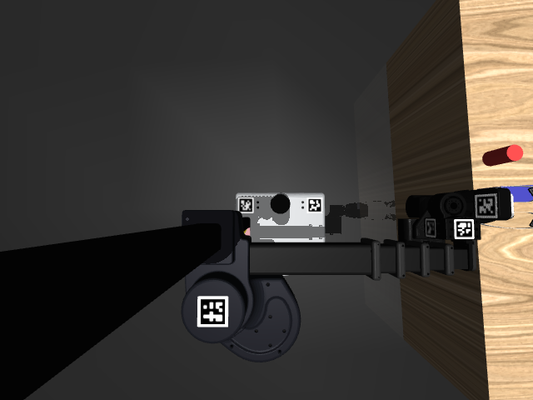

In [10]:
# blocking
sim.move_to('head_tilt', -2.0, timeout=120) # times out after 120s
media.show_image(sim.pull_camera_data().cam_nav_rgb, height=400)

In [11]:
# non-blocking
frames = []
for _ in range(10):
    sim.move_by('head_pan', -0.1)
    frames.append(sim.pull_camera_data().cam_nav_rgb)
    time.sleep(3)

media.show_video(frames, fps=15)

### Velocity control

Velocity control is available for the mobile base. The API is `set_base_velocity(<translation velocity>, <rotational velocity>)`. Each command is non-blocking.

In [12]:
# non-blocking
frames = []
for _ in range(10):
    sim.set_base_velocity(0.0, 1.0) # rotate in-place
    frames.append(sim.pull_camera_data().cam_nav_rgb)
    time.sleep(5)

media.show_video(frames, fps=15)

### Stopping the simulation

In [13]:
sim.stop()

Stopping Stretch Mujoco Simulator... simulated runtime= 24.7s
Sending signal to stop the Mujoco process...
The Mujoco process has ended.
Stopping thread 1/3.
Thread-2 is not terminating. Make sure to check 'sim.is_running()' in threading loops.
Stopping thread 2/3.
_colab_inspector_thread is not terminating. Make sure to check 'sim.is_running()' in threading loops.
Stopping thread 3/3.
Thread-8 is not terminating. Make sure to check 'sim.is_running()' in threading loops.
The Stretch Mujoco Simulator has ended. Good-bye!
